# 基于第二次世界大战天气状况的探索性数据分析与预测-part2-时间序列预测

## 任务目的

对二战中的空袭行动与天气状况数据进行分析，基于第二次世界大战中的空中轰炸行动和天气状况的多种数据源，利用 EDA (Exploratory Data Analysis)分析数据并对数据进行清理，根据时间序列预测方式，预测出轰炸目标城市、天气状况以及行动何时完成等。

## 任务内容

- 下载数据集
- 数据清洗
- 数据可视化
  - 袭击了多少个国家
  - 主要目标国家
  - 十大飞机系列
  - 起飞基地位置(攻击国家)
  - 目标位置
  - 轰炸路径
  - 战区
  - 气象站位置
- 基于 ARIMA 的时间序列预测
  - 时间序列的季节性趋势
  - 检查时间序列的平稳性
  - 避免趋势性和季节性的方法
  - 预测时间序列
  - 预测和可视化所有路径并查找均方误差


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

import plotly.graph_objs as go

# style of plots. ggplot is one of the most used style, I also like it.
plt.style.use("ggplot")

# import warnings library
import warnings

# ignore filters
# if there is a warning after some codes, this will avoid us to see them.
warnings.filterwarnings("ignore")

In [2]:
import os
import sys

data_path = "./data"
# 二战中的空中轰炸行动(Aerial Bombing Operations in WW2)
# 这一数据包括轰炸行动。例如，1945 年，美国使用庞特奥利沃机场炸弹德国(柏林)和A36 飞机。
aerial_path = os.path.join(data_path, "operations.csv")

# 二战期间的天气状况(Wether Conditions in WW2)
# 二战期间的天气状况。例如，根据乔治镇气象站，1942 年 1 月 7 日的平均气温是 23.88 度。该数据集中有 2 个子集：
# 第一个包括气象站的位置，如国家、纬度和经度。
weather_station_location_path = os.path.join(data_path, "Weather Station Locations.csv")
# 第二个包括气象站的测量最低、最高和平均温度。
weather_path = os.path.join(data_path, "Summary of Weather.csv")

In [3]:
aerial = pd.read_csv(aerial_path)
weather_station_location = pd.read_csv(weather_station_location_path)
weather = pd.read_csv(weather_path)

### 基于 ARIMA 的时间序列预测


#### 3.1 时间序列的季节性趋势


In [5]:
weather_station_id = weather_station_location[
    weather_station_location.NAME == "BINDUKURI"
].WBAN
weather_station_id

70    32907
Name: WBAN, dtype: int64

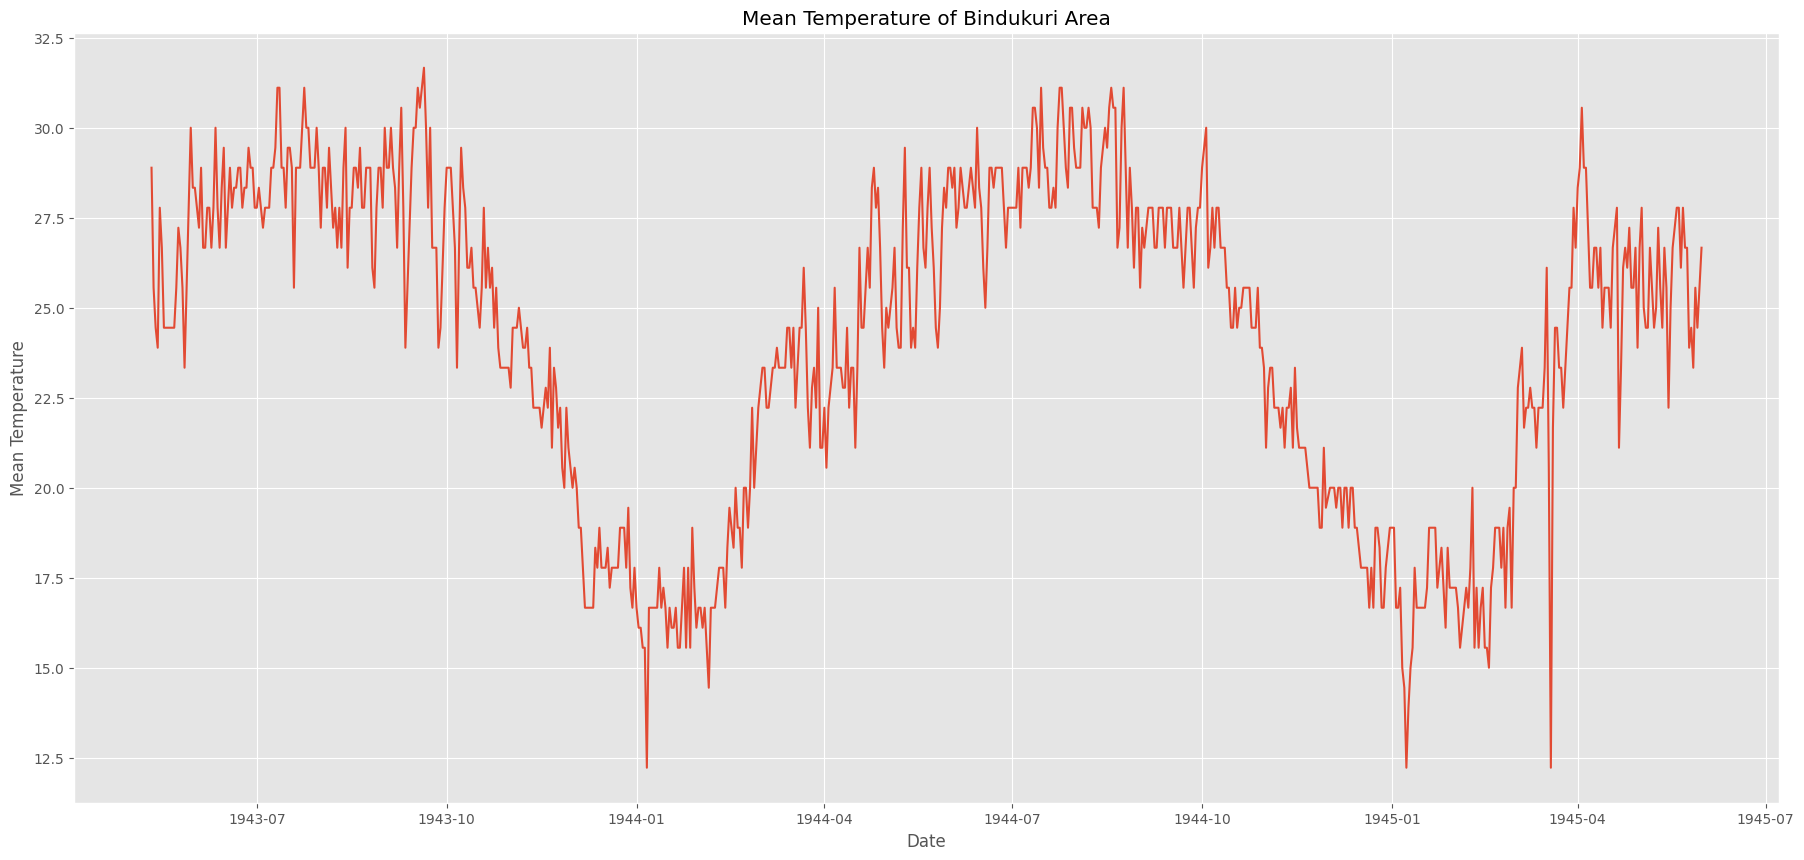

In [6]:
weather_bin = weather[weather.STA == 32907]
weather_bin["Date"] = pd.to_datetime(weather_bin["Date"])
plt.figure(figsize=(22, 10))
plt.plot(weather_bin.Date, weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

In [7]:
aerial = pd.read_csv(aerial_path)
aerial["year"] = [each.split("/")[2] for each in aerial["Mission Date"]]
aerial["month"] = [each.split("/")[0] for each in aerial["Mission Date"]]
aerial = aerial[aerial["year"] >= "1943"]
aerial = aerial[aerial["month"] >= "8"]

aerial["Mission Date"] = pd.to_datetime(aerial["Mission Date"])

attack = "USA"
target = "BURMA"
city = "KATHA"

aerial_war = aerial[aerial.Country == attack]
aerial_war = aerial_war[aerial_war["Target Country"] == target]
aerial_war = aerial_war[aerial_war["Target City"] == city]

In [10]:
mission_date_temperature = []

for each in aerial_war["Mission Date"]:
    """
         STA       Date   MeanTemp
78701  32907 1944-08-02  28.888889
    """
    dummy = weather_bin[weather_bin.Date == each]
    mission_date_temperature.append(dummy["MeanTemp"].values[0])

# Create a trace
trace = go.Scatter(
    x=weather_bin.Date,
    y=weather_bin.MeanTemp,
    mode="lines",
    name="Mean Temperature",
)
trace1 = go.Scatter(
    x=aerial_war["Mission Date"],
    y=mission_date_temperature,
    mode="markers",
    name="Bombing temperature",
)
layout = dict(
    title="Mean Temperature --- Bombing Dates and Mean Temperature at this Date"
)
data = [trace, trace1]

fig = dict(data=data, layout=layout)
iplot(fig)

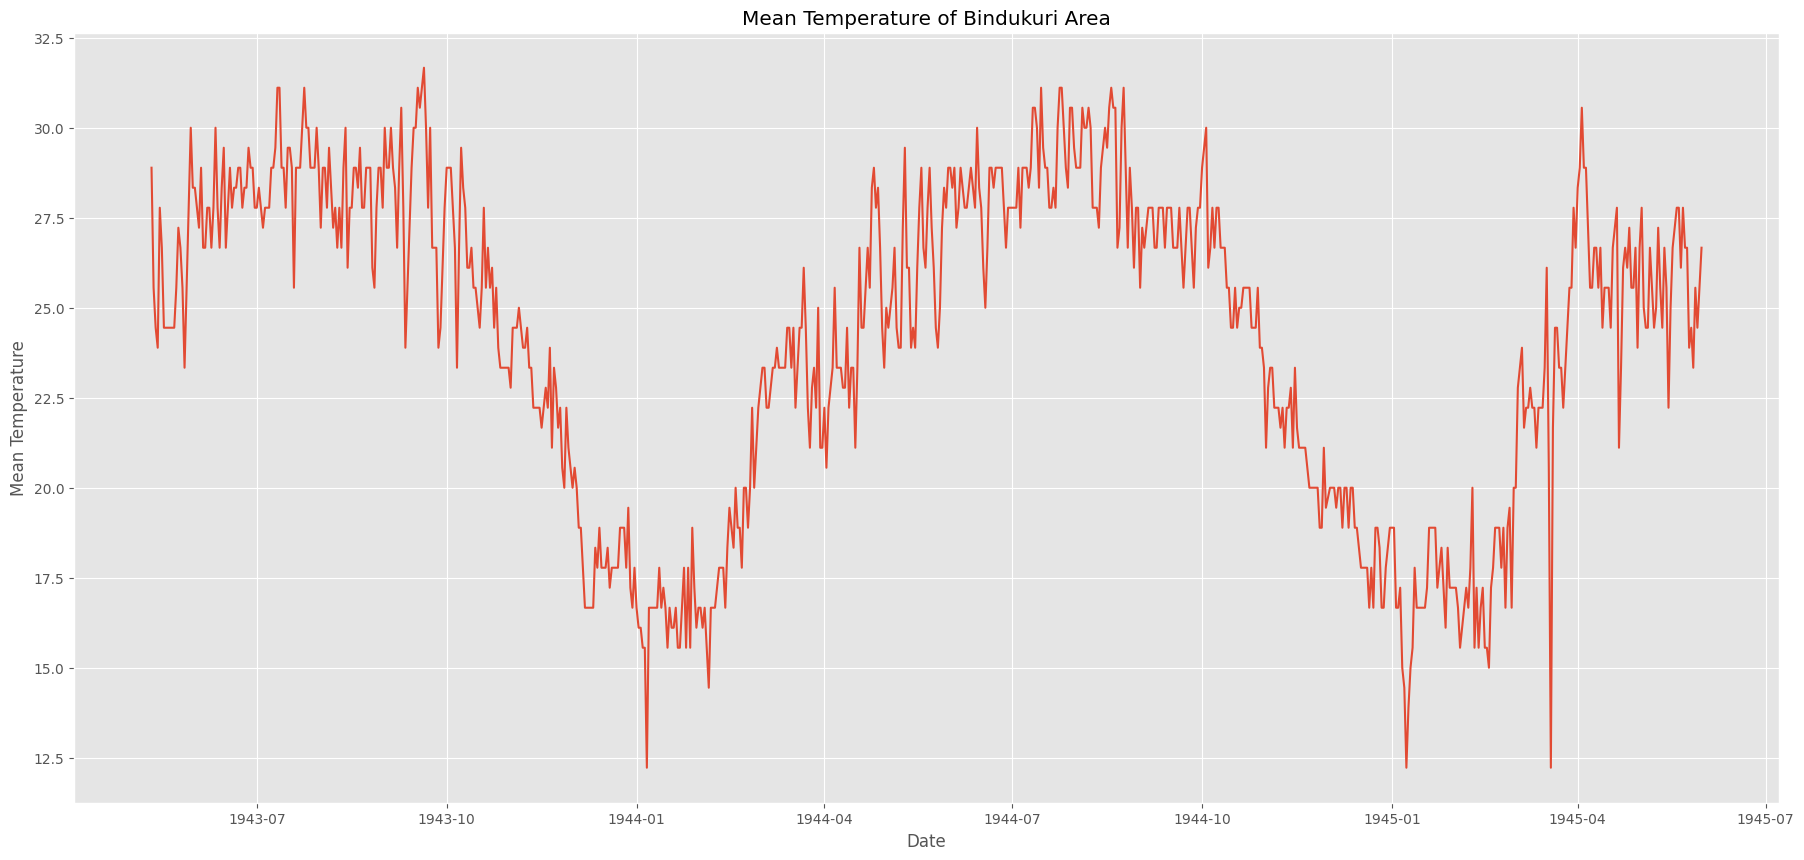

In [11]:
# Mean temperature of Bindikuri area
plt.figure(figsize=(22, 10))
plt.plot(weather_bin.Date, weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

# lets create time series from weather
timeSeries = weather_bin.loc[:, ["Date", "MeanTemp"]]
timeSeries.index = timeSeries.Date
ts = timeSeries.drop("Date", axis=1)

# 从图中可以看出，我们的时间序列存在季节性变化。每年夏季平均气温较高，冬季平均气温较低。

#### 3.2 检查时间序列的平稳性

时间序列有三个基本标准来了解它是否是平稳序列。

- 时间序列的统计特性(例如均值、方差)应随时间保持恒定，称为时间序列平稳
  - 常数均值
  - 常数方差
  - 不依赖于时间的自协方差。自协方差是时间序列和滞后时间序列之间的协方差。
- 可以使用以下方法检查平稳性：
  - 绘制滚动统计数据：我们有一个窗口，假设窗口大小为 6，然后我们找到滚动均值和方差来检查平稳性。
  - Dickey-Fuller 测试：测试结果包含测试统计量和差异置信水平的一些临界值。如果检验统计量小于临界值，我们可以说时间序列是平稳的。


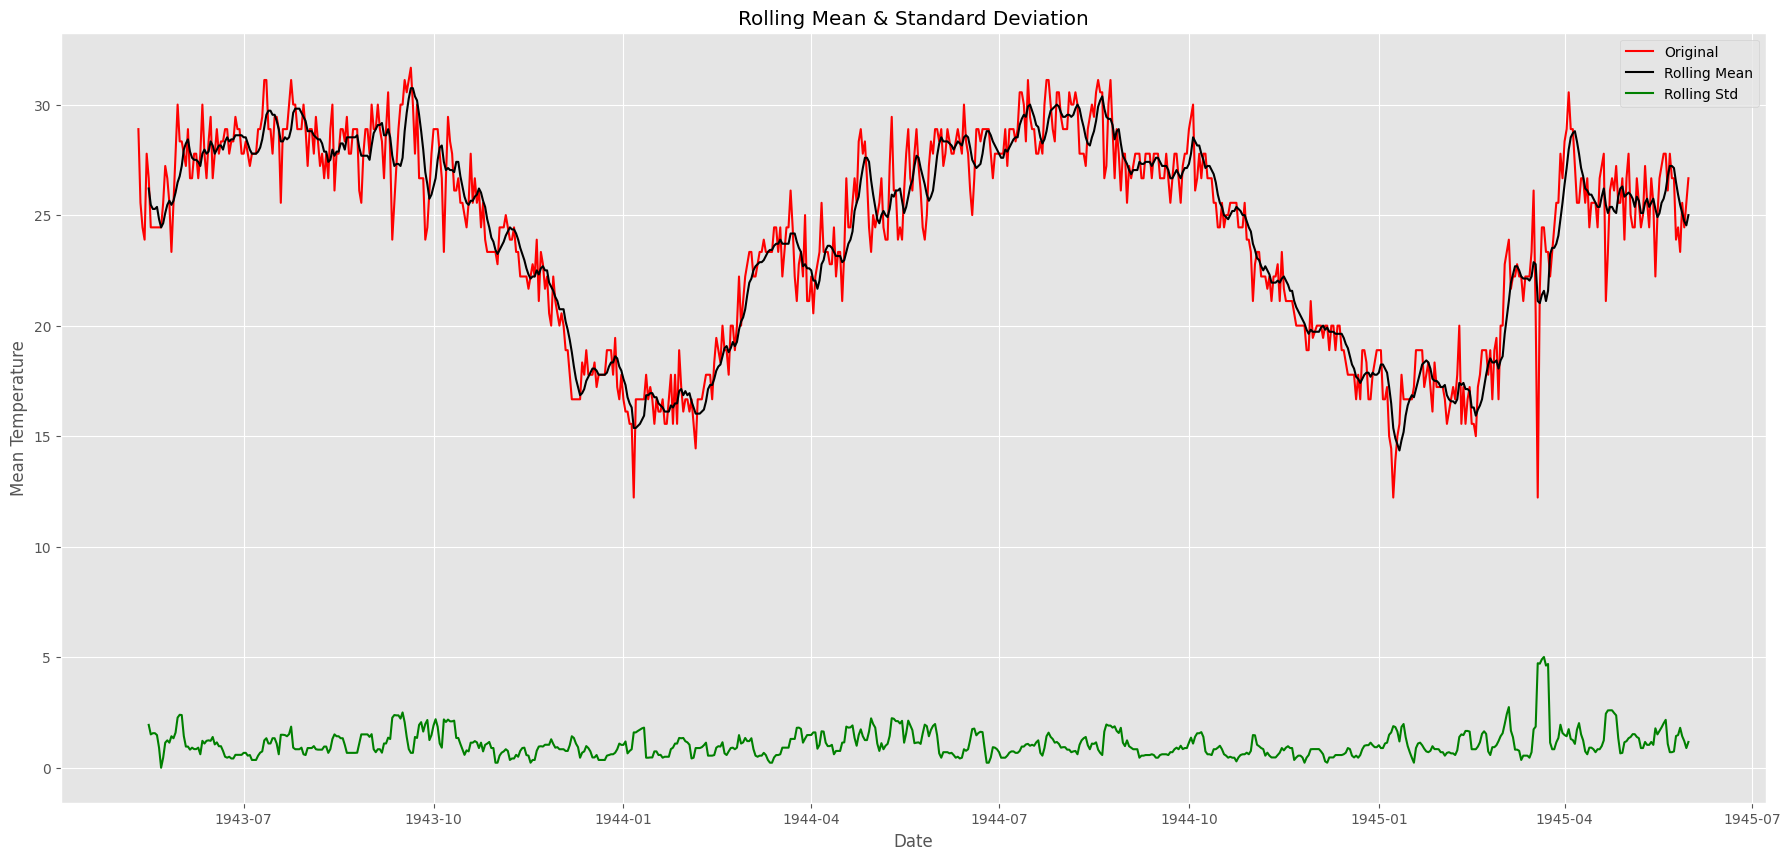

Test statistic:  -1.4095966745887756
p-value:  0.5776668028526357
Critical Values: {'1%': np.float64(-3.439229783394421), '5%': np.float64(-2.86545894814762), '10%': np.float64(-2.5688568756191392)}


In [14]:
# adfuller library
from statsmodels.tsa.stattools import adfuller


# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag="AIC")
    print("Test statistic: ", result[0])
    print("p-value: ", result[1])
    print("Critical Values:", result[4])


# check_mean_std
def check_mean_std(ts):
    # Rolling statistics
    rolmean = ts.rolling(window=6).mean()
    rolstd = ts.rolling(window=6).std()
    plt.figure(figsize=(22, 10))
    orig = plt.plot(ts, color="red", label="Original")
    mean = plt.plot(rolmean, color="black", label="Rolling Mean")
    std = plt.plot(rolstd, color="green", label="Rolling Std")
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title("Rolling Mean & Standard Deviation")
    plt.legend()
    plt.show()


# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts)
check_adfuller(ts.MeanTemp)

- 标准 1：常数均值-黑线，不是恒定的，测试失败；
- 标准 2：恒定方差-绿线，看起来比价拍平稳；
- 标准 3：检验统计量是否小于临界值：

```python
Test statistic:  -1.4095966745887756
p-value:  0.5776668028526357
Critical Values: {
    '1%': np.float64(-3.439229783394421),
    '5%': np.float64(-2.86545894814762),
    '10%': np.float64(-2.5688568756191392)}
```

- 检验统计量大于临界值，拒绝原假设，认为时间序列是不平稳的。


#### 3.3 使时间序列平稳

- 时间序列的非平稳性背后有两个原因
  - 趋势：随时间变化的平均值。我们需要时间序列的平稳常数均值。
  - 季节性：特定时间的变化。我们需要时间序列的平稳常数变化。
- 首先解决 **趋势(常均值)** 问题
  - 最流行的方法是移动平均线。
    - 移动平均线：我们有窗口，可以取过去 'n' 个样本的平均值。'n' 是窗口大小。


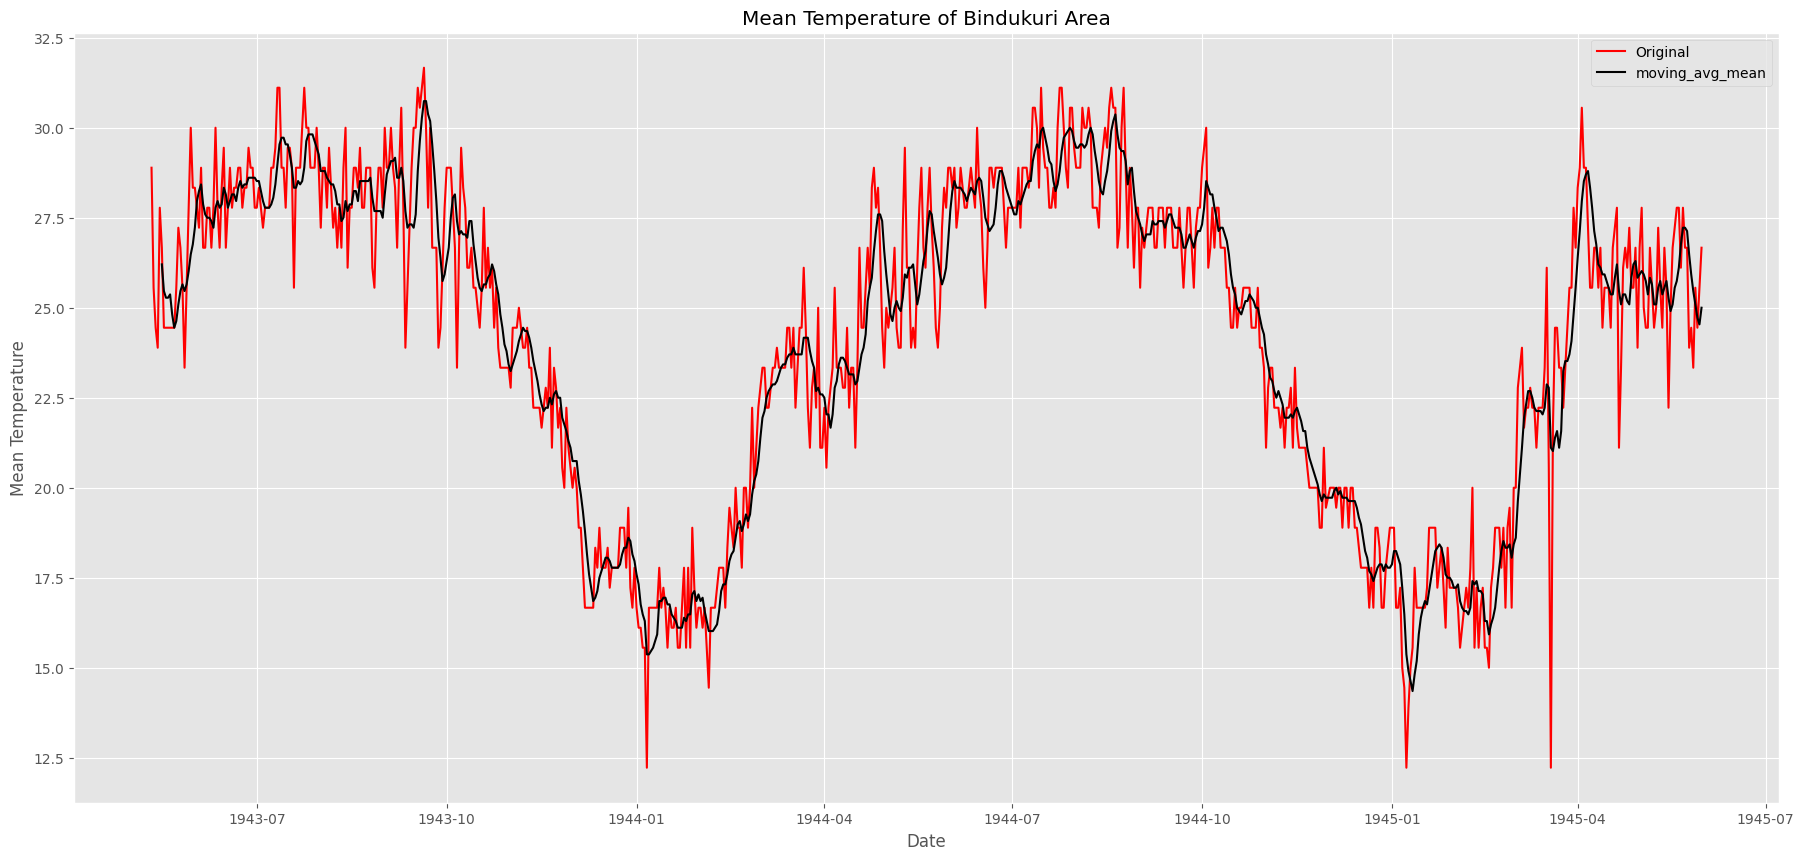

In [13]:
# Moving average method
window_size = 6
moving_avg = ts.rolling(window_size).mean()
plt.figure(figsize=(22, 10))
plt.plot(ts, color="red", label="Original")
plt.plot(moving_avg, color="black", label="moving_avg_mean")
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

In [ ]:
# ts_moving_avg_diff.MeanTemp

Date
1943-05-16    0.462963
1943-05-17   -1.018519
1943-05-18   -0.833333
1943-05-19   -0.833333
1943-05-20   -0.925926
                ...   
1945-05-27   -2.129630
1945-05-28    0.462963
1945-05-29   -0.277778
1945-05-30    1.018519
1945-05-31    1.666667
Name: MeanTemp, Length: 746, dtype: float64

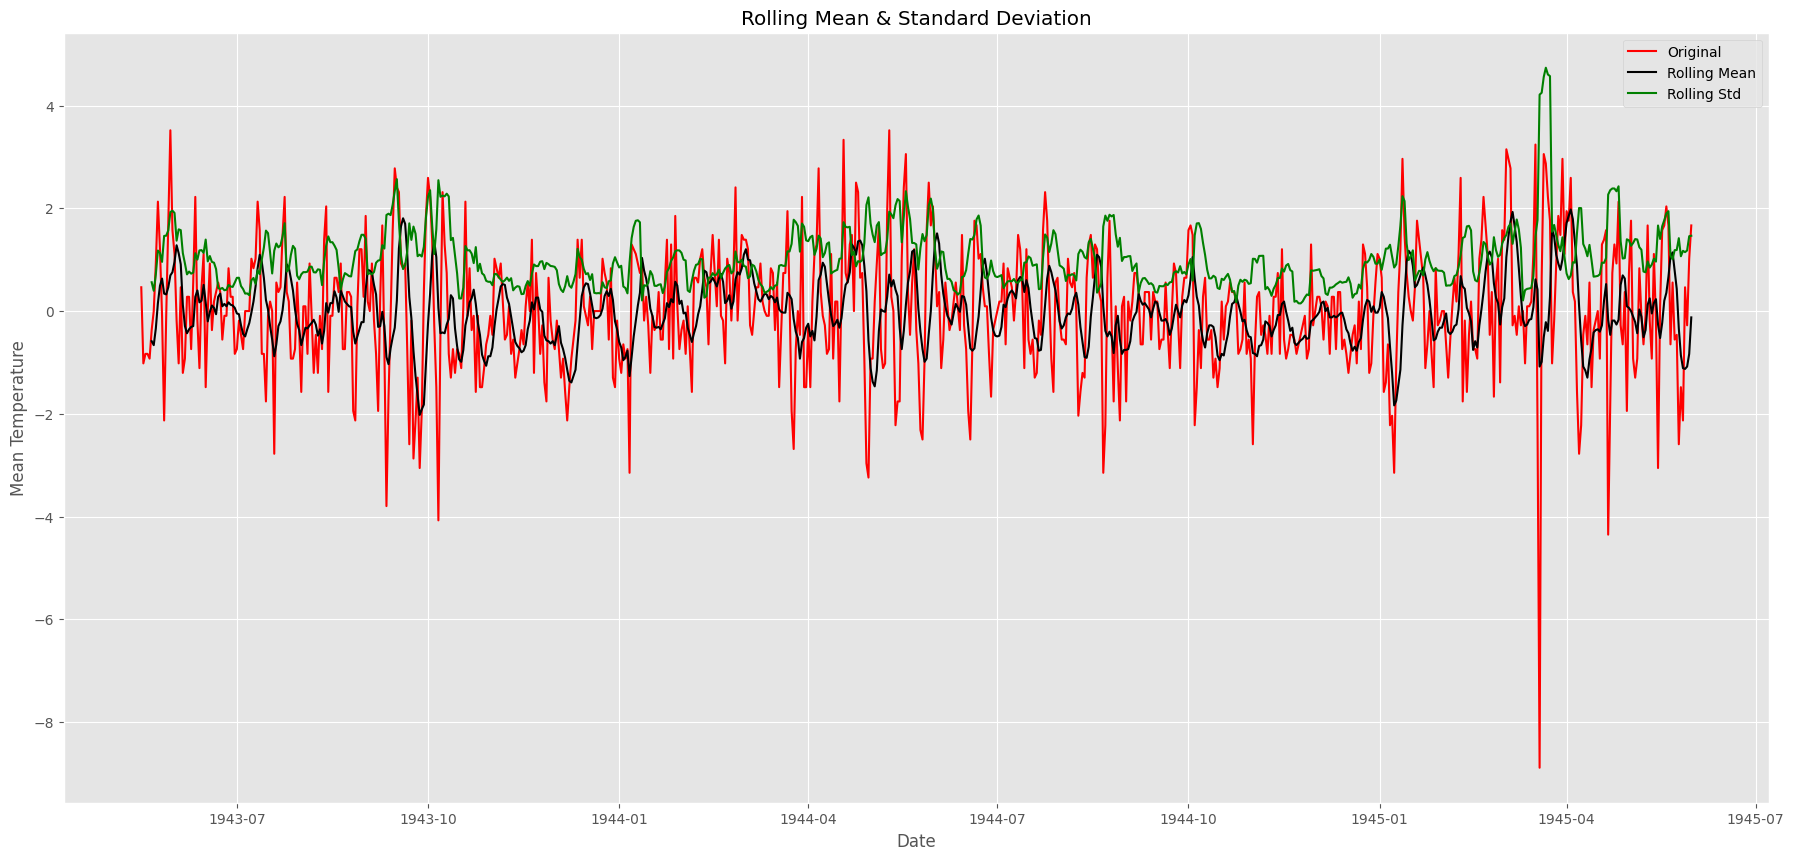

Test statistic:  -11.1385143351385
p-value:  3.150868563164087e-20
Critical Values: {'1%': np.float64(-3.4392539652094154), '5%': np.float64(-2.86546960465041), '10%': np.float64(-2.5688625527782327)}


In [15]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True)  # first 6 is nan value due to window size

# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_moving_avg_diff)
check_adfuller(ts_moving_avg_diff.MeanTemp)

* 常数均值标准：均值看起来像常数(黑线)；
* 第二个是常数方差。它看起来是恒定的(绿线)；
* 检验统计量小于 1% 的临界值，因此我们可以有 99% 的置信度说这是一个平稳序列。
  

* 另一种避免趋势和季节性的方法：
    * 差分方法：这是最常用的方法之一。想法是时间序列和偏移时间序列之间的差异。

#### 3.4 避免趋势性和季节性的方法

- 差分法：是最常用的方法之一。其思想是取时间序列和移位时间序列之间的差。
- 常量平均值标准：从上面的图（黑线）可以看出，平均值看起来像常量(静止）。
- 第二个是常数方差。它看起来是恒定的(静止）
- 检验统计量小于 1%的临界值，所以 99%的置信度说这是一个平稳序列(是（静止）

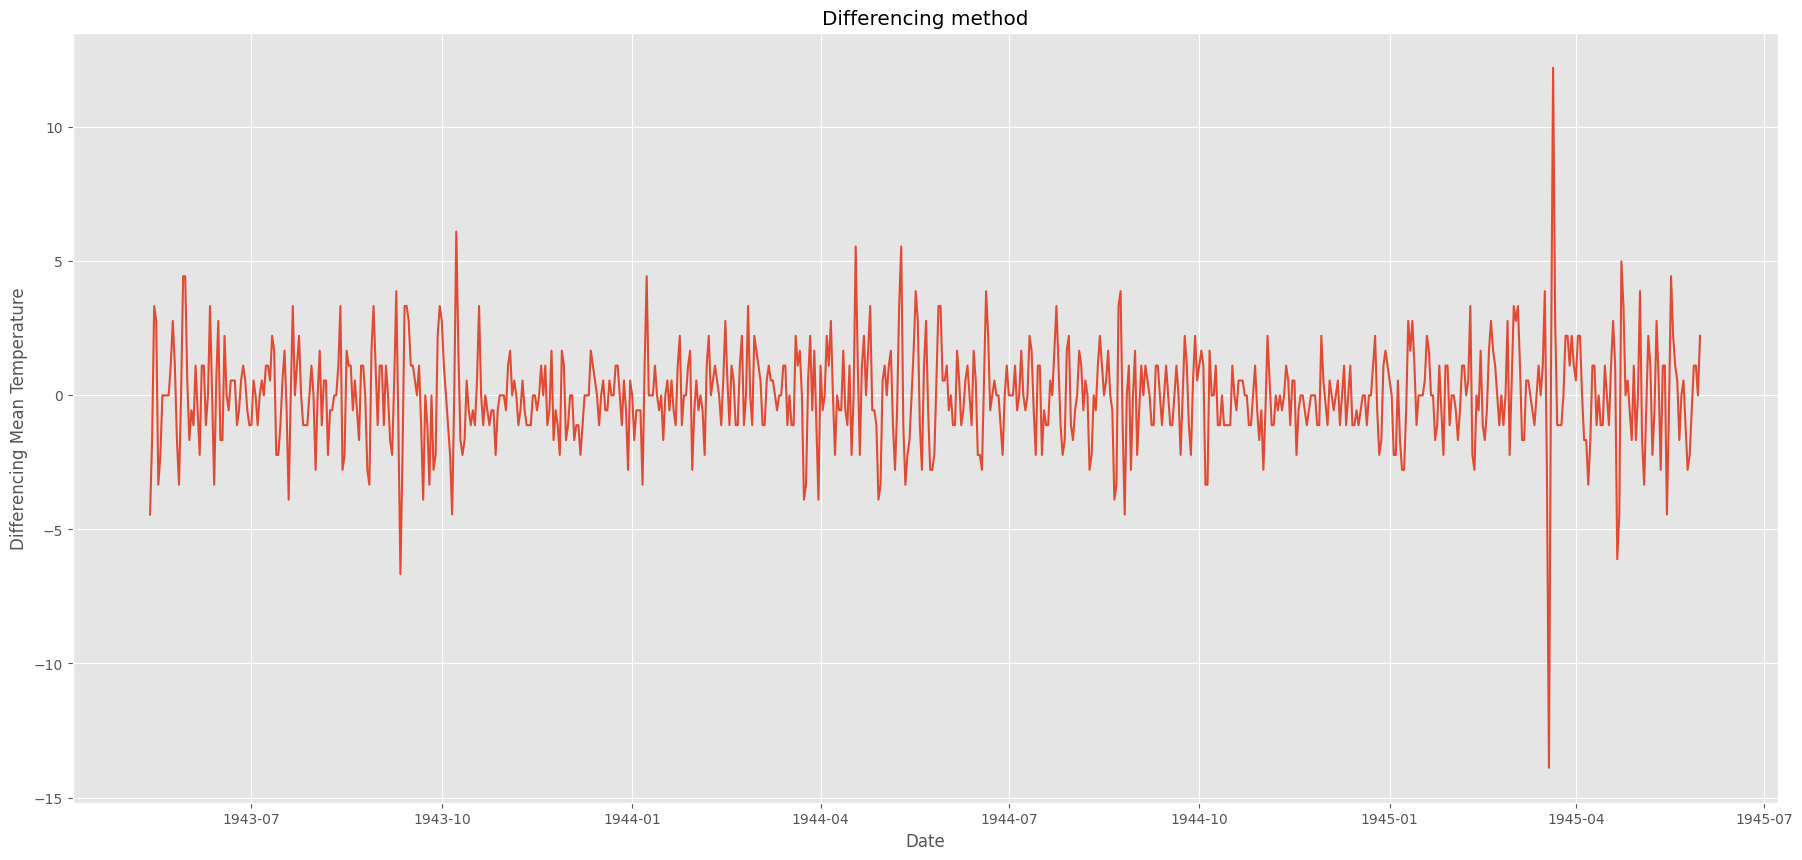

In [25]:
# differencing method
ts_diff = ts - ts.shift(periods=2)  # differencing, shift periods days
plt.figure(figsize=(22, 10))
plt.plot(ts_diff)
plt.title("Differencing method")
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

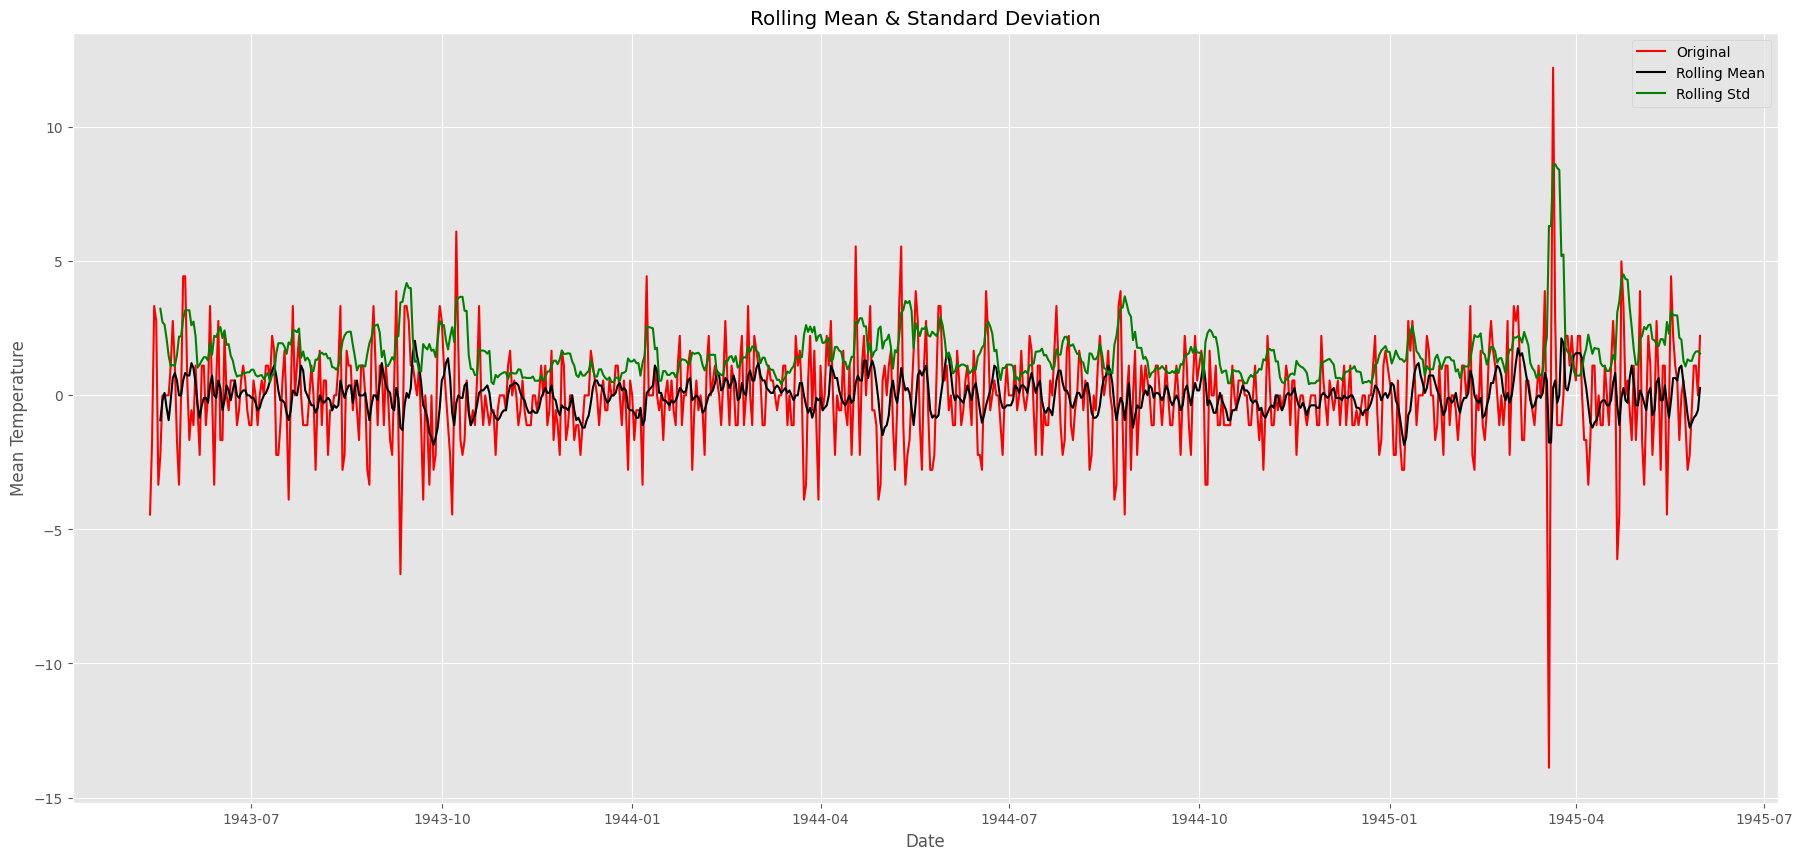

Test statistic:  -6.632435819198499
p-value:  5.670635412264921e-09
Critical Values: {'1%': np.float64(-3.4393396487377155), '5%': np.float64(-2.865507363200066), '10%': np.float64(-2.5688826684180897)}


In [26]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_diff)
check_adfuller(ts_diff.MeanTemp)

* 常数均值标准：均值看起来像常数(黑线)；
* 第二个是常数方差。它看起来是恒定的(绿线)；
* 检验统计量小于 1% 的临界值，因此我们可以有 99% 的置信度说这是一个平稳序列。

#### 3.5 预测时间序列

- 使用了两种不同的方法，即**移动平均和差分**方法，以避免趋势和季节性问题。
- 对于预测(预测)，我们将使用差分方法得到的时间序列 `ts_diff`。我选择它没有特别的理由。
- 预测方法使用的是 ARIMA，即自回归积分移动平均模型。
  - AR：自回归(p)：AR 项只是因变量的滞后项。例如，假设 p 为 3，我们将使用 `x(t-1)`、`x(t-2)` 和 `x(t-3)` 来预测 `x(t)`。
  - I：积分(d)：这些是非季节性差异的数量。例如，在我们的例子中，我们进行了第一次差分。因此，我们传递该变量并设置 d=0。
  - MA：移动平均(q)：MA 项是预测方程中的滞后预测误差。
- `(p,d,q)` 是 ARIMA 模型的参数。
- 为了选择 p,d,q 参数，我们将使用两种不同的图。
  - 自相关函数(ACF)：测量时间序列与其滞后版本之间的相关性。
  - 偏自相关函数(PACF)：这测量时间序列与其滞后版本之间的相关性，但在消除已由中间比较解释的变异之后。


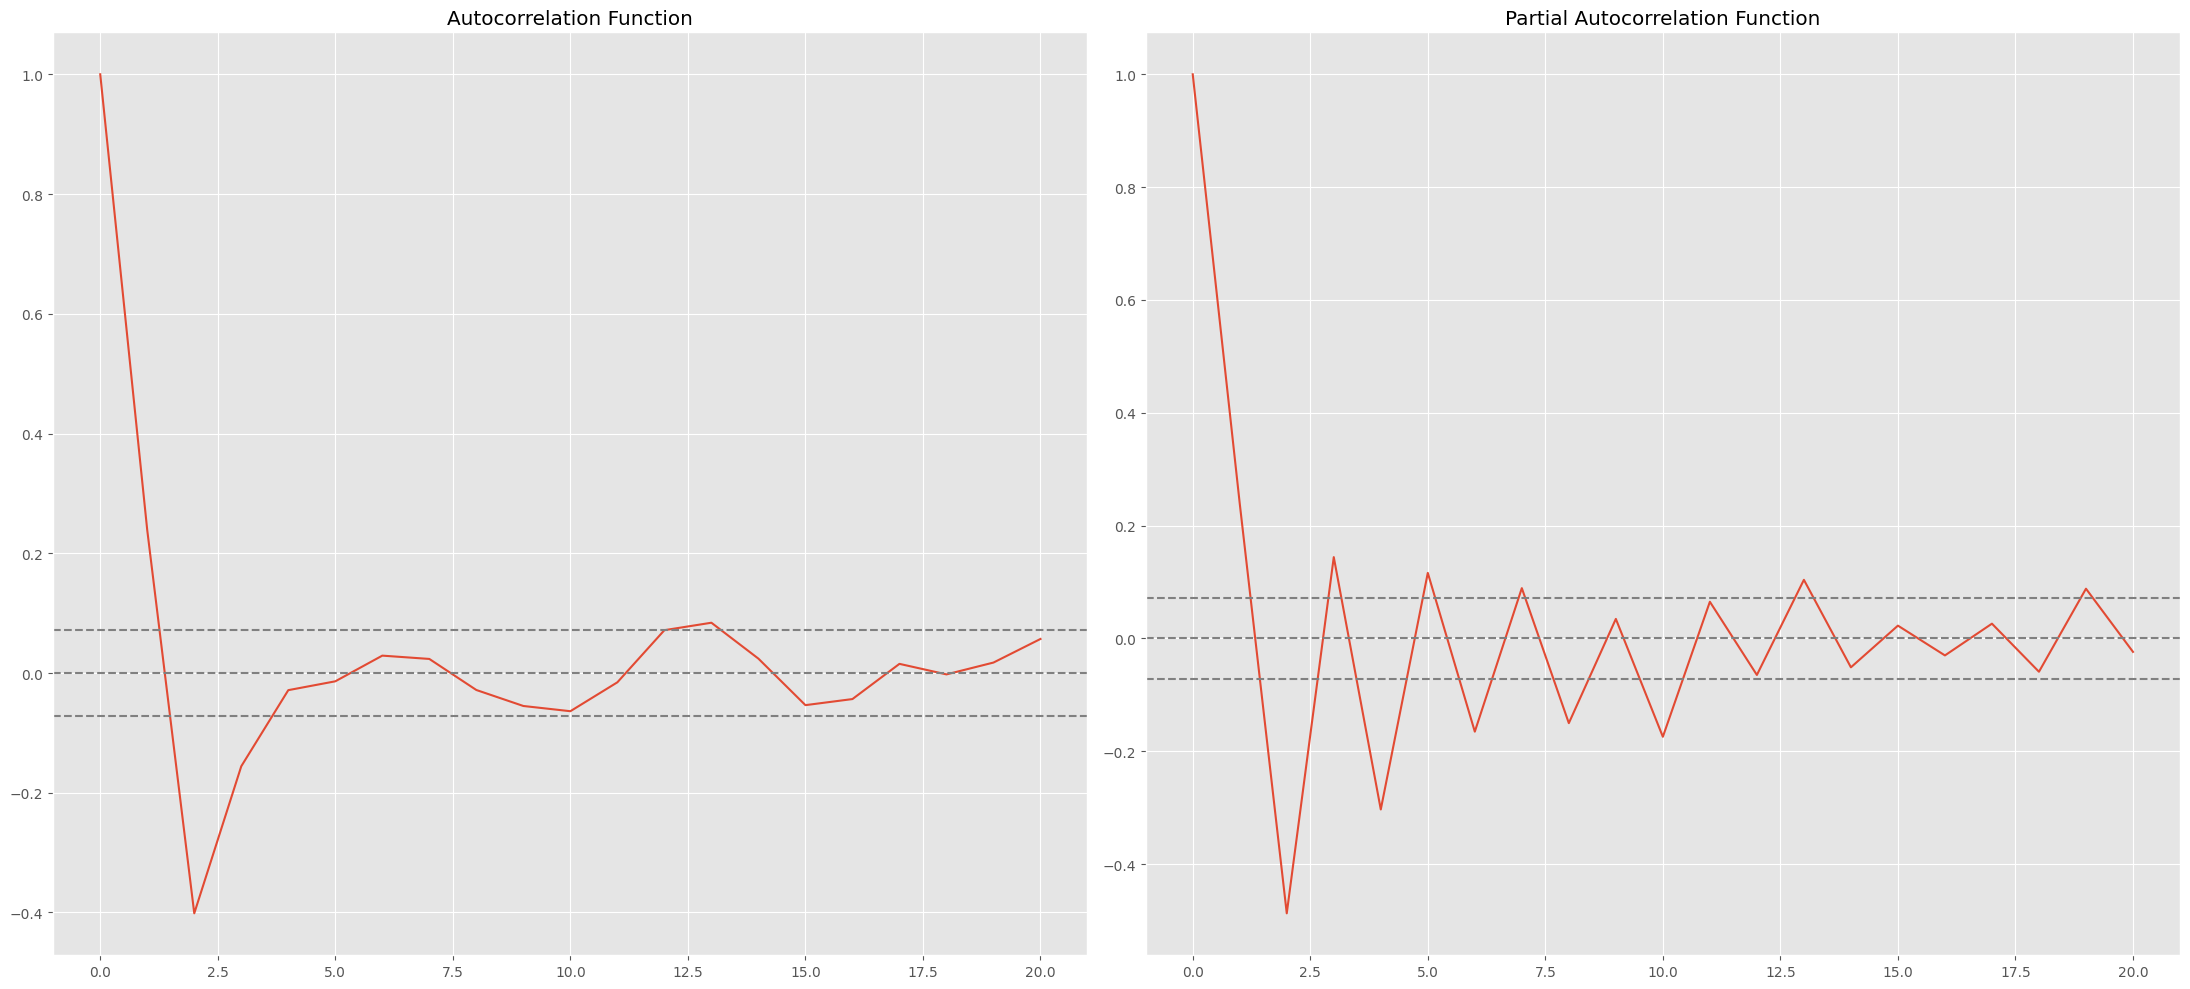

In [27]:
# ACF and PACF
from statsmodels.tsa.stattools import acf, pacf
# Calculate the autocorrelation function.
lag_acf = acf(ts_diff, nlags=20)
# Partial autocorrelation estimate.
lag_pacf = pacf(ts_diff, nlags=20, method="ols")
# ACF
plt.figure(figsize=(22, 10))

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff)), linestyle="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(ts_diff)), linestyle="--", color="gray")
plt.title("Autocorrelation Function")

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff)), linestyle="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(ts_diff)), linestyle="--", color="gray")
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

#### 使用 `(1,0,1)` 作为 ARIMA 模型的参数并预测

- 两条虚线是置信区间。我们使用这些线来确定‘p’和‘q’值。
  - 选择 p：PACF 图第一次穿过上置信区间的滞后值。p=1。
  - 选择 q：ACF 图第一次穿过上置信区间的滞后值。q=1。
- 现在让我们使用(1,0,1)作为 ARIMA 模型的参数并进行预测。
  - ARIMA：来自 statsmodels 库。
  - datetime：我们将使用它来指定预测方法的开始和结束索引。


/home/hhw/miniconda3/envs/ai24/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/hhw/miniconda3/envs/ai24/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/hhw/miniconda3/envs/ai24/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



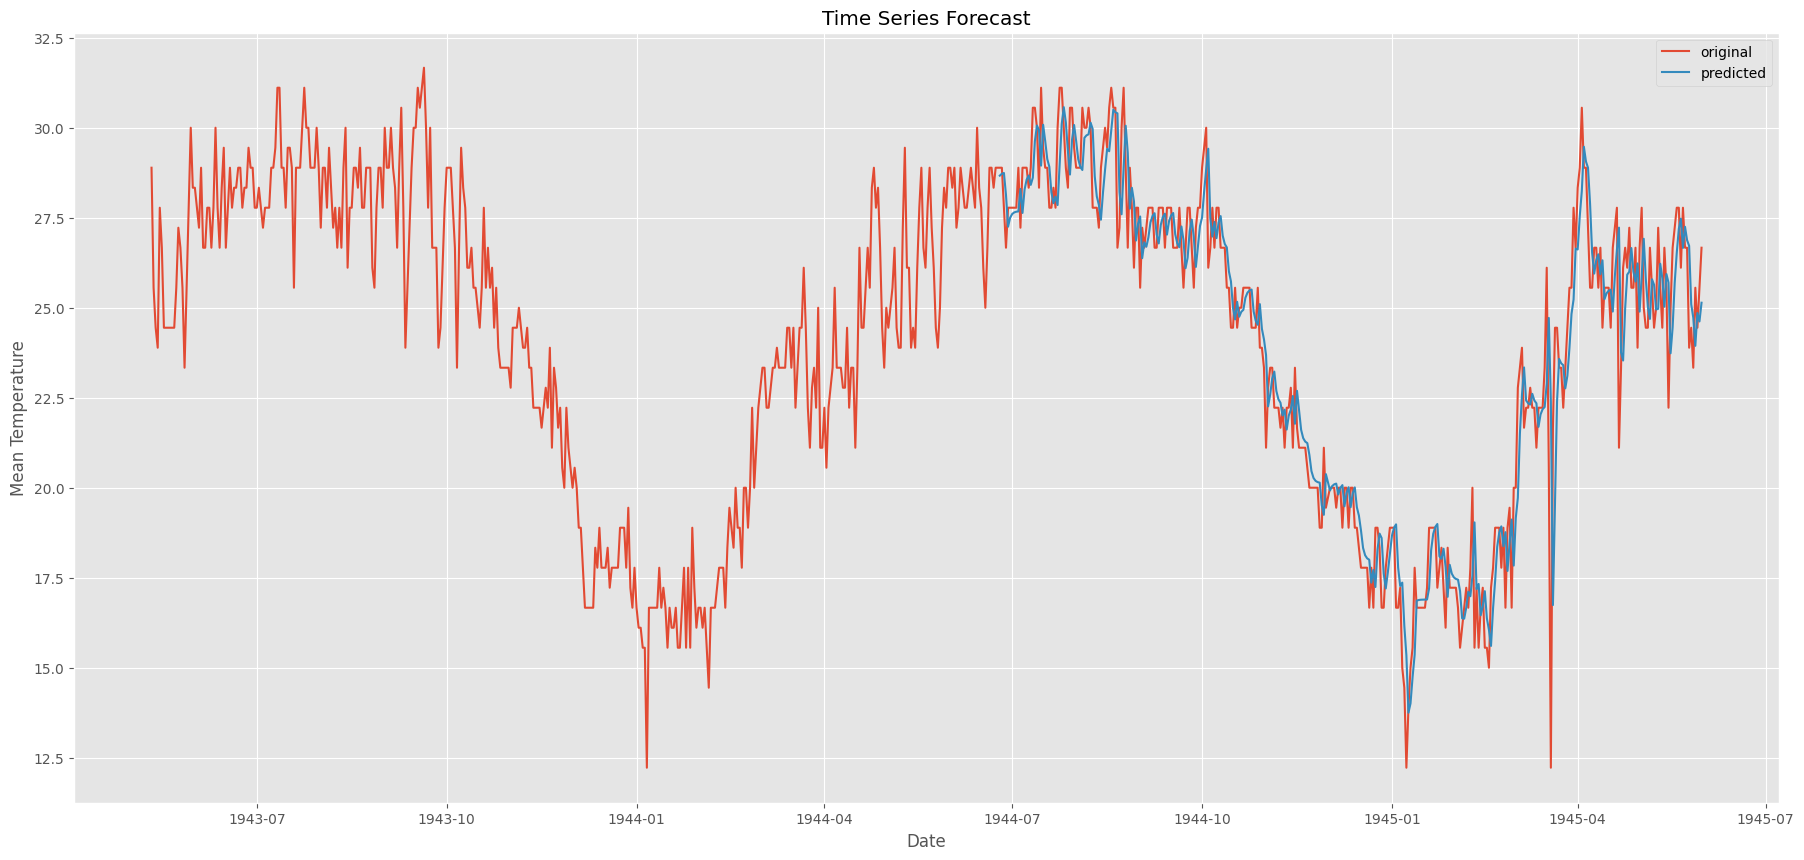

In [24]:
# ARIMA LİBRARY
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
# from pandas import datetime
from datetime import datetime

# fit model
model = ARIMA(ts, order=(1, 0, 1))  # (ARMA) = (1,0,1)
model_fit = model.fit()

# predict
start_index = datetime(1944, 6, 25)
end_index = datetime(1945, 5, 31)
forecast = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22, 10))
plt.plot(weather_bin.Date, weather_bin.MeanTemp, label="original")
plt.plot(forecast, label="predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

#### 预测和可视化所有路径并查找均方误差


/home/hhw/miniconda3/envs/ai24/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/hhw/miniconda3/envs/ai24/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/hhw/miniconda3/envs/ai24/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



error:  1.8625810278777963


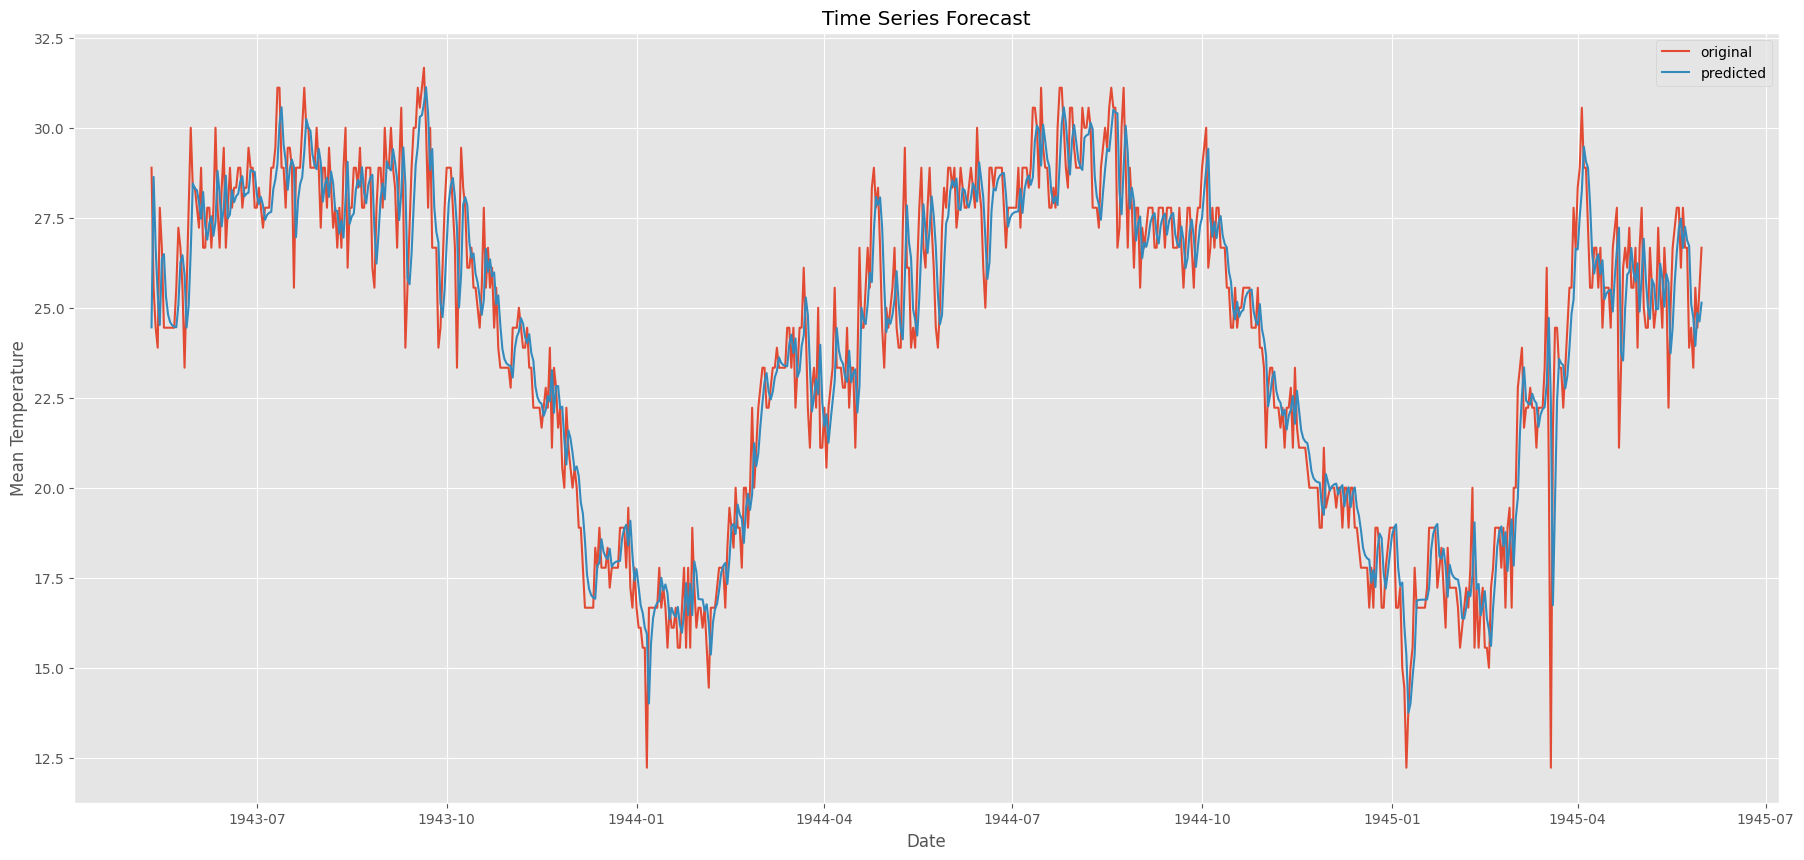

In [26]:
# predict all path
from sklearn.metrics import mean_squared_error

# fit model
model2 = ARIMA(ts, order=(1, 0, 1))  # (ARMA) = (1,0,1)
model_fit2 = model2.fit()
forecast2 = model_fit2.predict()
error = mean_squared_error(ts, forecast2)
print("error: ", error)
# visualization
plt.figure(figsize=(22, 10))
plt.plot(weather_bin.Date, weather_bin.MeanTemp, label="original")
plt.plot(forecast2, label="predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.savefig("graph.png")

plt.show()